In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
from pathlib import Path

def Respiration(
    file,
    water_volume_L=2.0,
    chamber_headspace_L=None,
    bucket_inner_diameter_cm=29.0,
    bucket_inner_height_cm=33.0,
    chamber_height_above_rim_cm=27.0,
    P=None,
):

    # --- 0. Ensure path is correct ---
    script_dir = Path().resolve()     # folder where the script is saved
    file_path = script_dir / file     # file relative to that folder

    if not file_path.exists():
        raise FileNotFoundError(f"CSV file not found: {file_path}")

    
    # --- 1. Load the data ---
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip() # clean up spaces in col names
    
    
    # --- 2. Convert time ---
    if "datetime" in df.columns:
        df["time"] = pd.to_datetime(df["datetime"], errors="coerce")
    else:
        df["time"] = pd.to_datetime(df["stampunix"], unit="s", errors="coerce")
    
    
    # --- 3. Identify CO2 column ---
    co2_col = [c for c in df.columns if c.upper().startswith("K33_CO2")]
    if not co2_col:
        raise ValueError("No K33_CO2 column found in CSV")
    co2_col = co2_col[0]
    
    
    # --- 4. Compute chamber headspace volume ---
    if chamber_headspace_L is None:
        r_m = (bucket_inner_diameter_cm / 100.0) / 2.0
        bucket_volume_m3 = np.pi * r_m**2 * (bucket_inner_height_cm / 100.0)
        bucket_volume_L = bucket_volume_m3 * 1000.0
        
        
        # water displaces part of bucket volume
        headspace_in_bucket_L = max(bucket_volume_L - water_volume_L, 0.0)
        
        
        # chamber volume above rim
        chamber_height_m = chamber_height_above_rim_cm / 100.0
        chamber_volume_m3 = np.pi * r_m**2 * chamber_height_m
        chamber_volume_L_calc = chamber_volume_m3 * 1000.0
        
        
        chamber_headspace_L = headspace_in_bucket_L + chamber_volume_L_calc
        print(
        f"Computed headspace: {chamber_headspace_L:.2f} L (bucket headspace {headspace_in_bucket_L:.2f} L + chamber {chamber_volume_L_calc:.2f} L)"
        )
    else:
        print(f"Using provided chamber headspace: {chamber_headspace_L:.2f} L")
    
    
    V = chamber_headspace_L / 1000.0 # L → m³
    A = np.pi * ((bucket_inner_diameter_cm / 100.0) / 2.0) ** 2 # m² footprint
    
    
    if P is None:
        P = 101325.0 # Pa
    R = 8.314 # J/mol/K
    
    
    # --- 5. Clean CO2 data ---
    df[co2_col] = pd.to_numeric(df[co2_col], errors="coerce")
    df = df.dropna(subset=[co2_col, "stampunix"]).reset_index(drop=True)
    
    
    # remove rows with zero CO2 values
    df = df[df[co2_col] > 0].reset_index(drop=True)
    
    
    # --- 6. Use all valid points as closure segment ---
    if len(df) < 4:
        raise ValueError("Not enough data points to fit slope")
    
    
    t0 = df["stampunix"].iloc[0]
    x = (df["stampunix"] - t0).astype(float).values # seconds since start
    y = df[co2_col].values
    
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    
    # --- 7. Convert slope to flux and respiration ---
    T_K = df["tempC"].mean() + 273.15 if "tempC" in df.columns else 298.15
    
    
    slope_fraction = slope * 1e-6 # ppm/s → mol/mol/s
    
    
    # flux in µmol m⁻² s⁻¹
    flux = slope_fraction * (P * V) / (R * T_K * A) * 1e6
    
    
    # total respiration (µmol/s, whole bucket)
    R_total = flux * A
    
    
    # respiration per L water (µmol L⁻¹ s⁻¹)
    R_water = R_total / water_volume_L
    
    
    results = {
    "n_points": len(df),
    "start_time": df["time"].iloc[0],
    "end_time": df["time"].iloc[-1],
    "slope_ppm_s": float(slope),
    "r2": float(r_value**2),
    "flux_umol_m2_s": float(flux),
    "respiration_umol_s": float(R_total),
    "respiration_umol_L_s": float(R_water),
    }
    
    
    print("Results:")
    for k, v in results.items():
        print(f"{k}: {v}")
    
    
    # --- 8. Plot ---
    plt.figure()
    plt.scatter(x, y, s=10, label="data")
    plt.plot(x, intercept + slope * x, "r", label=f"slope={slope:.3f} ppm/s")
    plt.xlabel("Seconds since start")
    plt.ylabel("CO₂ (ppm)")
    plt.title("Respiration chamber data")
    plt.legend()
    plt.show()
    
    
    return results

In [3]:
# ---------------------- USER INPUTS ----------------------
# Path to your CSV file
file = "B-A1.csv"  # File name

# Physical setup (you told me: 2 L of biofloc water)
water_volume_L = 2.0  # liters

# If you know the chamber/headspace volume directly (in liters), set it here.
# If left as None, the script will compute headspace from bucket and chamber dimensions below.
chamber_headspace_L = None  # liters (set non-None if you measured it)

# Bucket / chamber geometry (used only if chamber_headspace_L is None)
bucket_inner_diameter_cm = 29.0  # internal diameter of bucket opening (cm)
bucket_inner_height_cm = 33.0    # internal height of bucket (cm)
chamber_height_above_rim_cm = 27.0  # height of chamber above bucket rim (cm)

# Chamber footprint / area — if chamber seals on top of the bucket opening, area = π*(d/2)^2
# You can override this if your chamber has a different footprint.

# Atmospheric pressure (Pa). Leave None to use 101325 Pa.
P = None

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-03-07 08:06:53
end_time: 2025-03-07 08:16:29
slope_ppm_s: -0.029035168834267988
r2: 0.39702026635454
flux_umol_m2_s: -0.6755629401728019
respiration_umol_s: -0.044622273556819414
respiration_umol_L_s: -0.022311136778409707


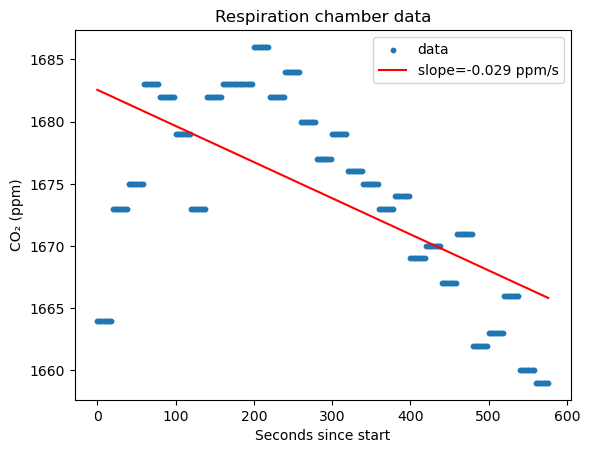

{'n_points': 289,
 'start_time': Timestamp('2025-03-07 08:06:53'),
 'end_time': Timestamp('2025-03-07 08:16:29'),
 'slope_ppm_s': -0.029035168834267988,
 'r2': 0.39702026635454,
 'flux_umol_m2_s': -0.6755629401728019,
 'respiration_umol_s': -0.044622273556819414,
 'respiration_umol_L_s': -0.022311136778409707}

In [4]:
Respiration(file)

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-03-07 08:06:53
end_time: 2025-03-07 08:16:29
slope_ppm_s: -0.029035168834267988
r2: 0.39702026635454
flux_umol_m2_s: -0.6755629401728019
respiration_umol_s: -0.044622273556819414
respiration_umol_L_s: -0.022311136778409707


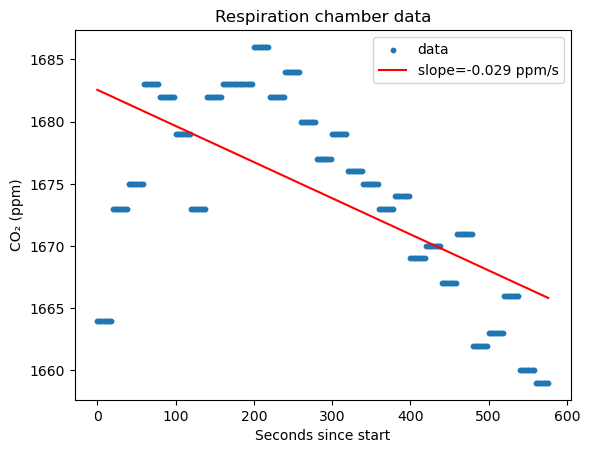

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-03-07 08:19:38
end_time: 2025-03-07 08:29:36
slope_ppm_s: -0.05547217191302126
r2: 0.8343551269917099
flux_umol_m2_s: -1.2862495619440746
respiration_umol_s: -0.08495933746858064
respiration_umol_L_s: -0.04247966873429032


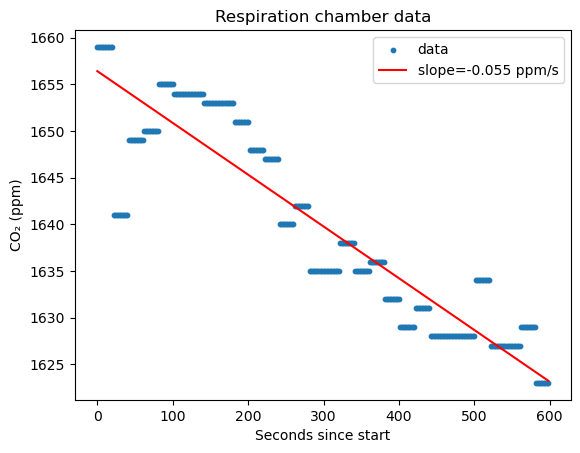

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-03-07 08:06:52
end_time: 2025-03-07 08:16:28
slope_ppm_s: -0.10291010420395338
r2: 0.8872336389577018
flux_umol_m2_s: -2.3982954230349427
respiration_umol_s: -0.15841217460709023
respiration_umol_L_s: -0.07920608730354511


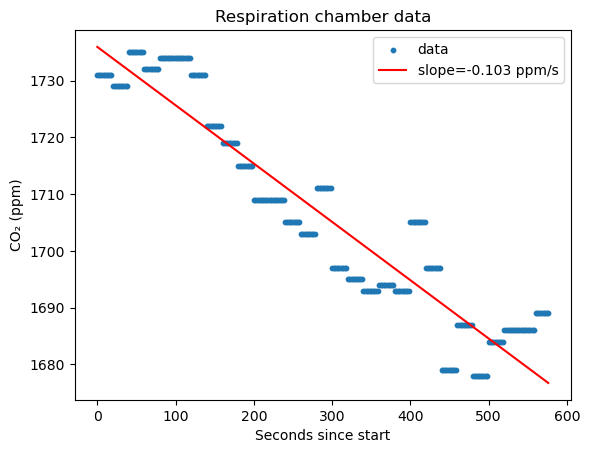

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-03-07 08:06:53
end_time: 2025-03-07 08:16:29
slope_ppm_s: 0.002084327645865646
r2: 0.0033093712519753557
flux_umol_m2_s: 0.0485604165374002
respiration_umol_s: 0.003207511931028521
respiration_umol_L_s: 0.0016037559655142605


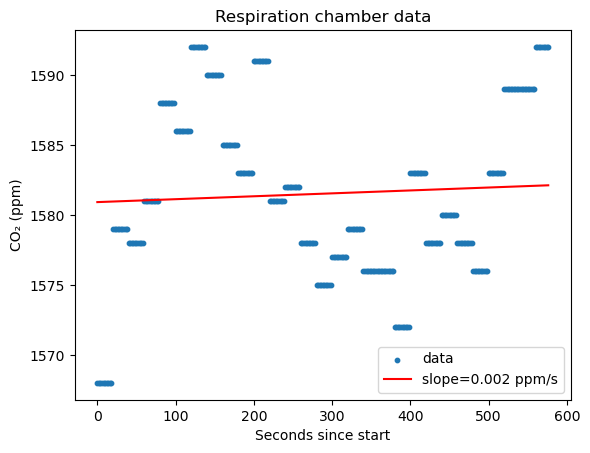

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-03-07 08:19:39
end_time: 2025-03-07 08:29:36
slope_ppm_s: -0.010627856334170478
r2: 0.04393684770395817
flux_umol_m2_s: -0.24684727759292333
respiration_umol_s: -0.016304752810582045
respiration_umol_L_s: -0.008152376405291022


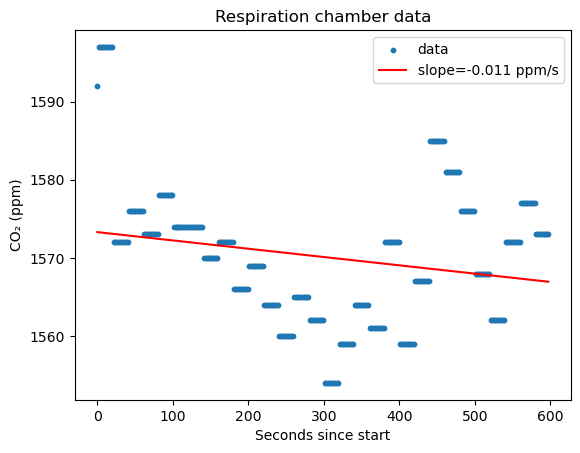

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-03-07 08:32:46
end_time: 2025-03-07 08:42:44
slope_ppm_s: -0.008754986166512962
r2: 0.044388759195375084
flux_umol_m2_s: -0.20324183441346053
respiration_umol_s: -0.01342452670815164
respiration_umol_L_s: -0.00671226335407582


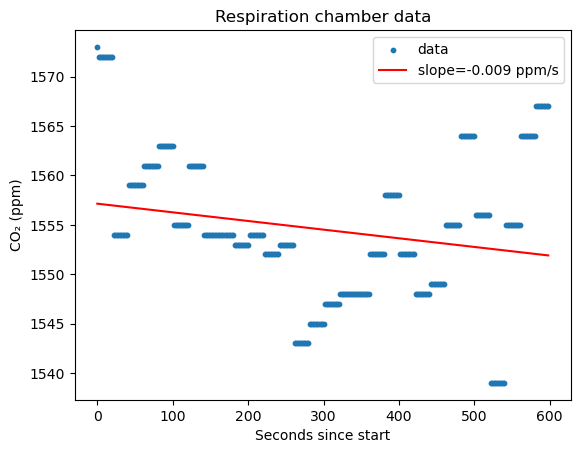

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-03-07 08:06:52
end_time: 2025-03-07 08:16:28
slope_ppm_s: -0.18099346736666266
r2: 0.8376622779967193
flux_umol_m2_s: -4.219181677775695
respiration_umol_s: -0.27868532717835287
respiration_umol_L_s: -0.13934266358917644


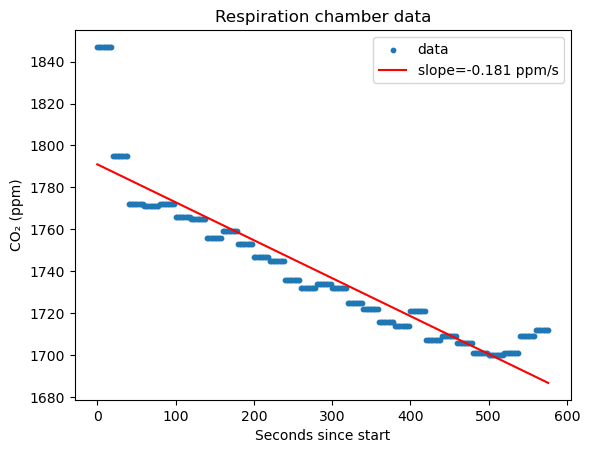

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-03-07 08:19:38
end_time: 2025-03-07 08:29:35
slope_ppm_s: -0.08423221731536983
r2: 0.7007392182627636
flux_umol_m2_s: -1.9582911942491539
respiration_umol_s: -0.12934902164903328
respiration_umol_L_s: -0.06467451082451664


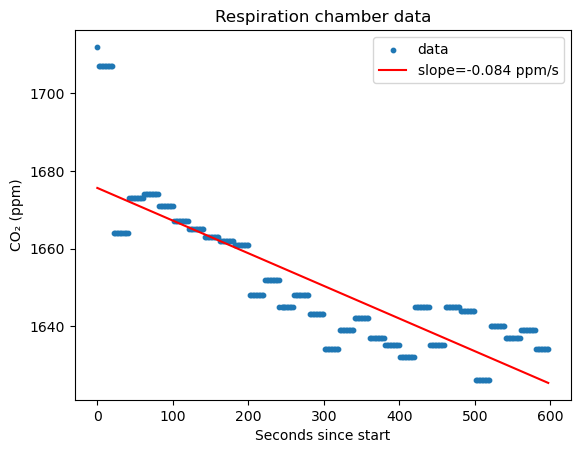

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-03-07 08:32:45
end_time: 2025-03-07 08:42:43
slope_ppm_s: -0.04368081867576307
r2: 0.4496679059507909
flux_umol_m2_s: -1.0152928384693576
respiration_umol_s: -0.06706210788719534
respiration_umol_L_s: -0.03353105394359767


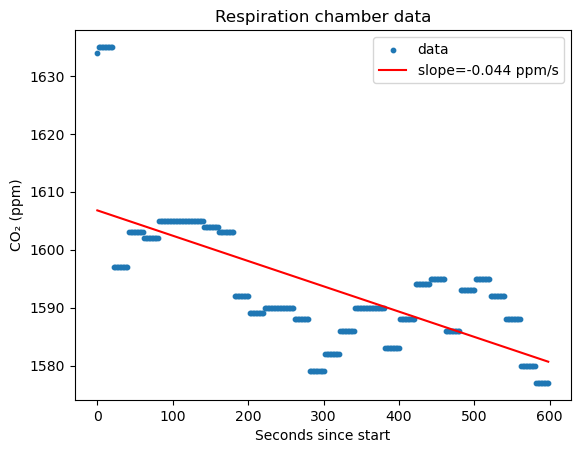

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-09-26 13:06:33
end_time: 2025-09-26 13:16:10
slope_ppm_s: -0.009643230193499924
r2: 0.08681935194132277
flux_umol_m2_s: -0.22554547412902745
respiration_umol_s: -0.01489772639617212
respiration_umol_L_s: -0.00744886319808606


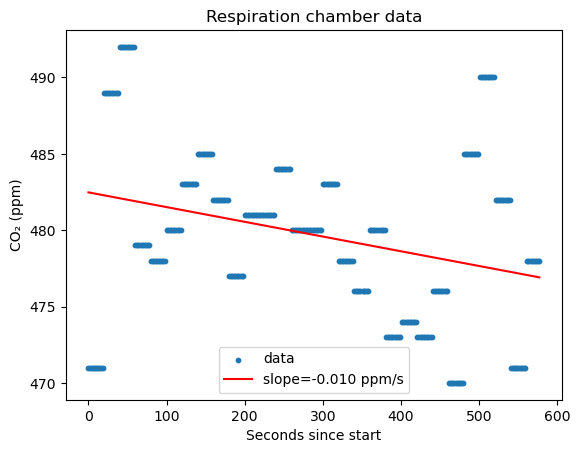

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-09-26 13:19:21
end_time: 2025-09-26 13:29:20
slope_ppm_s: -0.01661936950348522
r2: 0.0893140696723708
flux_umol_m2_s: -0.38820403754126154
respiration_umol_s: -0.02564164747491483
respiration_umol_L_s: -0.012820823737457415


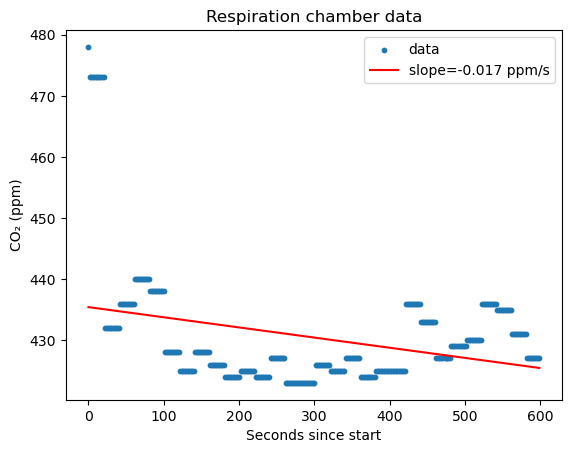

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-09-26 14:04:39
end_time: 2025-09-26 14:14:16
slope_ppm_s: -0.12064225793883235
r2: 0.6538210132093851
flux_umol_m2_s: -2.8215539728394994
respiration_umol_s: -0.18636924221919246
respiration_umol_L_s: -0.09318462110959623


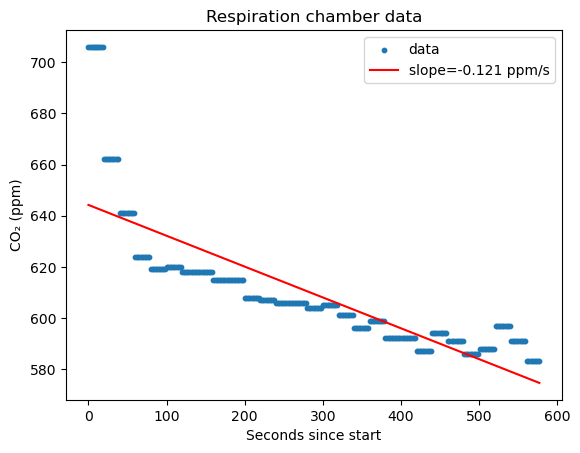

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 289
start_time: 2025-09-26 14:43:37
end_time: 2025-09-26 14:53:14
slope_ppm_s: -0.032307962208405996
r2: 0.6095523885502239
flux_umol_m2_s: -0.7557325495699423
respiration_umol_s: -0.0499176354376051
respiration_umol_L_s: -0.02495881771880255


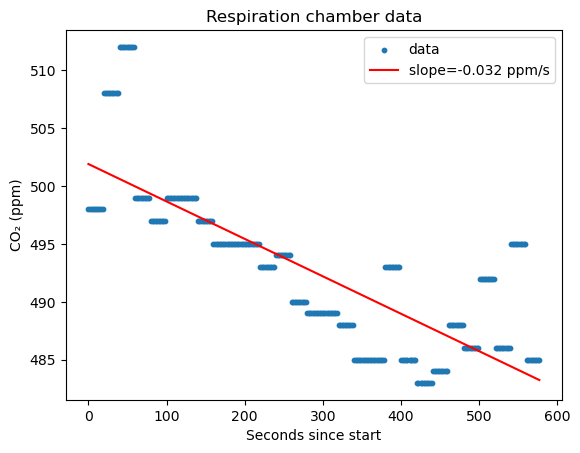

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-09-26 14:56:25
end_time: 2025-09-26 15:06:24
slope_ppm_s: -0.0180105989958197
r2: 0.0934797190223276
flux_umol_m2_s: -0.4209142718181915
respiration_umol_s: -0.027802223396441058
respiration_umol_L_s: -0.013901111698220529


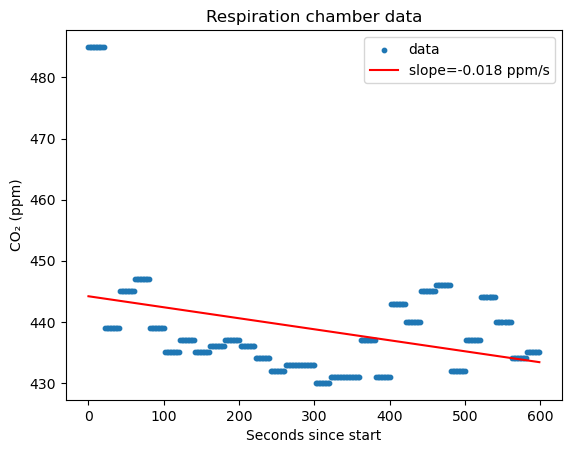

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 301
start_time: 2025-09-26 15:09:34
end_time: 2025-09-26 15:19:35
slope_ppm_s: -0.002742226544118597
r2: 0.005590205822987696
flux_umol_m2_s: -0.06406584484000531
respiration_umol_s: -0.004231676257090453
respiration_umol_L_s: -0.0021158381285452266


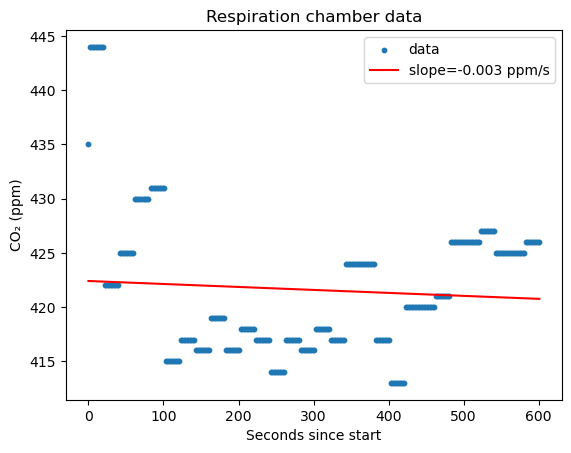

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 288
start_time: 2025-09-26 15:50:59
end_time: 2025-09-26 16:00:36
slope_ppm_s: -0.0920565736641324
r2: 0.9490520042836618
flux_umol_m2_s: -2.153210739544941
respiration_umol_s: -0.14222384463671028
respiration_umol_L_s: -0.07111192231835514


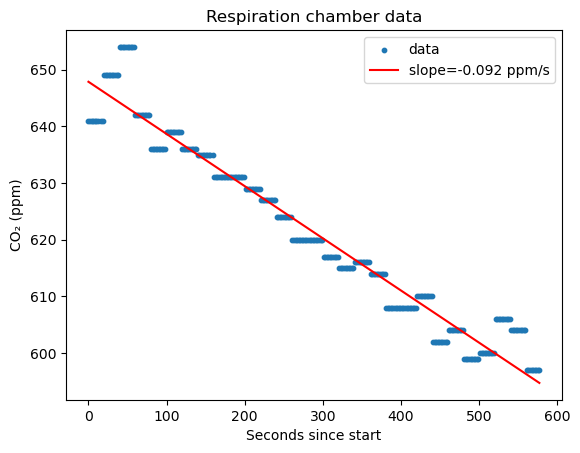

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 300
start_time: 2025-09-26 16:03:47
end_time: 2025-09-26 16:13:46
slope_ppm_s: -0.06769208985787249
r2: 0.12767030646925256
flux_umol_m2_s: -1.5818505911555911
respiration_umol_s: -0.10448437237617887
respiration_umol_L_s: -0.052242186188089436


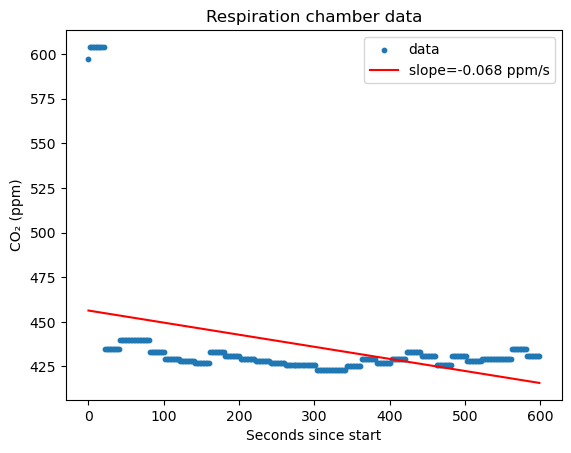

Computed headspace: 37.63 L (bucket headspace 19.80 L + chamber 17.83 L)
Results:
n_points: 301
start_time: 2025-09-26 16:16:57
end_time: 2025-09-26 16:26:58
slope_ppm_s: 0.0013127081183017322
r2: 0.0009589538775626296
flux_umol_m2_s: 0.030669403676908295
respiration_umol_s: 0.0020257750082404865
respiration_umol_L_s: 0.0010128875041202432


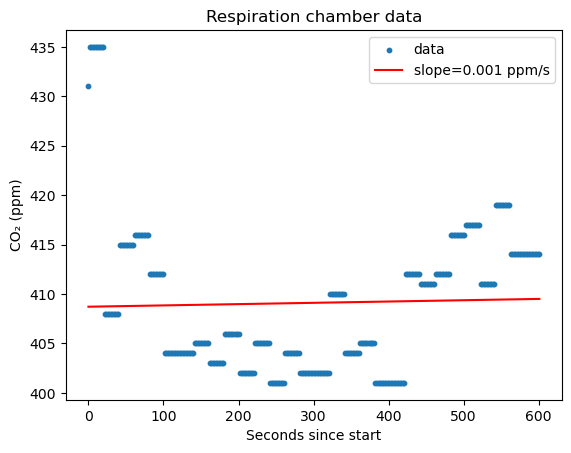

In [5]:
files = ['B-A1.csv', 'B-A2.csv', 'B-A3.csv', 'B-D1.csv', 'B-D2.csv', 'B-D3.csv','B-S1.csv', 'B-S2.csv', 'B-S3.csv',
        'C-1-1.csv', 'C-1-2.csv', 'C-1-3.csv','C-2-1.csv', 'C-2-2.csv', 'C-2-3.csv','C-3-1.csv', 'C-3-2.csv', 'C-3-3.csv',]
Names = ['Bacteria A (R1)','Bacteria A (R2)', 'Bacteria A (R3)','Bacteria D (R1)','Bacteria D (R2)', 'Bacteria D (R3)',
        'Bacteria S (R1)','Bacteria S (R2)', 'Bacteria S (R3)','Control 1 (R1)', 'Control 1 (R2)', 'Control 1 (R3)',
         'Control 2 (R1)', 'Control 2 (R2)', 'Control 2 (R3)','Control 3 (R1)', 'Control 3 (R2)', 'Control 3 (R3)',]

# Amount of water 
water_volume_L = 2.0

# Measured Bucket / chamber geometry
bucket_inner_diameter_cm = 29.0  # internal diameter of bucket opening (cm)
bucket_inner_height_cm = 33.0    # internal height of bucket (cm)
chamber_height_above_rim_cm = 27.0  # height of chamber above bucket rim (cm)


all_results = []
for i in range(len(files)):
    res = Respiration(files[i],
                      water_volume_L=water_volume_L,
                      chamber_headspace_L=None,
                      bucket_inner_diameter_cm=bucket_inner_diameter_cm,
                      bucket_inner_height_cm=bucket_inner_height_cm,
                      chamber_height_above_rim_cm=chamber_height_above_rim_cm,
                      P=None)
    if res is not None:
        res["Name"] = Names[i]
        all_results.append(res)

df_results = pd.DataFrame(all_results)
df_results.to_csv("Respiration_Results.csv", index=False)


Average per bucket:
    Treatment  mean_start_ppm  mean_end_ppm  mean_ppm   std_ppm  mean_resp  \
0  Bacteria A     1684.666667   1657.000000 -0.062472  0.037432  -0.726685   
1  Bacteria D     1577.666667   1577.333333 -0.005766  0.006863  -0.066921   
2  Bacteria S     1731.000000   1641.000000 -0.102969  0.070548  -1.198794   
3   Control 1      551.666667    496.000000 -0.048968  0.062169  -0.572551   
4   Control 2      472.666667    448.666667 -0.017687  0.014786  -0.206785   
5   Control 3      556.333333    480.666667 -0.052812  0.048431  -0.617399   

   std_resp  n  
0  0.436720  3  
1  0.079732  3  
2  0.823250  3  
3  0.727063  3  
4  0.172946  3  
5  0.566275  3  

Average per group (Bacteria vs Control):
      Group  mean_start_ppm  mean_end_ppm  mean_ppm   std_ppm  mean_resp  \
0  Bacteria     1664.444444   1625.111111 -0.057069  0.058261  -0.664133   
1   Control      526.888889    475.111111 -0.039822  0.043424  -0.465578   

   std_resp  n  
0  0.679058  9  
1  0.507

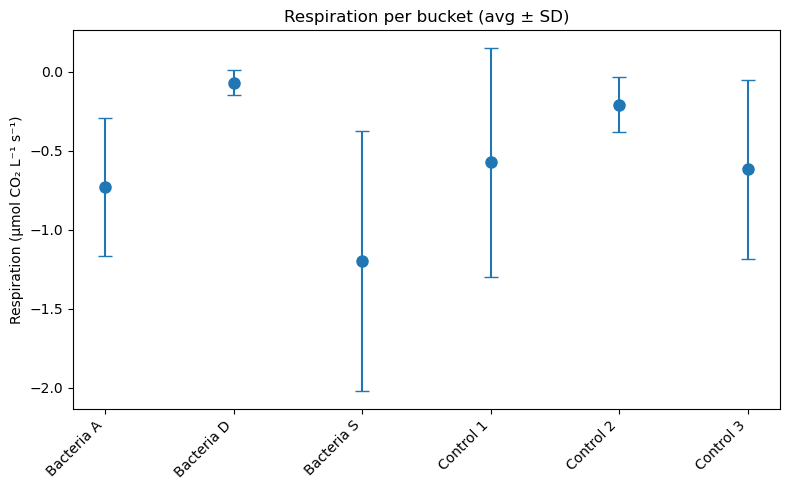

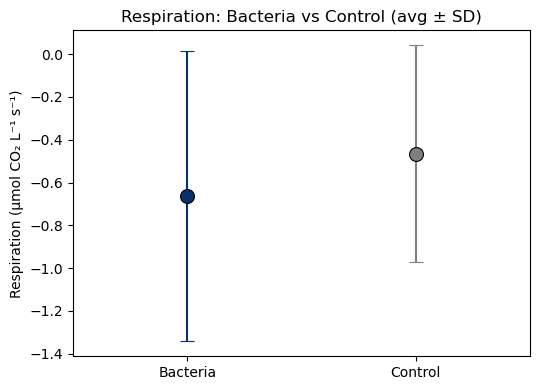


Average ± SD per Group:
Bacteria: -0.664 ± 0.679
Control: -0.466 ± 0.508


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ---------- Respiration function ----------
def Respiration(file, water_volume_L=2.0,
                chamber_headspace_L=None,
                bucket_inner_diameter_cm=29.0,
                bucket_inner_height_cm=33.0,
                chamber_height_above_rim_cm=27.0,
                P=None):
    
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()
    
    # detect CO2 column
    co2_col = [c for c in df.columns if c.upper().startswith("K33_CO2")][0]
    
    # remove zeros and NaN
    df = df[df[co2_col] > 0].dropna(subset=["stampunix"]).reset_index(drop=True)
    if len(df) < 5:
        return None
    
    # compute headspace volume if not provided
    r_m = (bucket_inner_diameter_cm/100.0)/2.0
    bucket_volume_L = np.pi * r_m**2 * (bucket_inner_height_cm/100.0) * 1000
    headspace_in_bucket_L = max(bucket_volume_L - water_volume_L, 0.0)
    chamber_volume_L = np.pi * r_m**2 * (chamber_height_above_rim_cm/100.0) * 1000
    if chamber_headspace_L is None:
        chamber_headspace_L = headspace_in_bucket_L + chamber_volume_L
    
    # convert to SI units
    V = chamber_headspace_L / 1000.0  # m³
    A = np.pi * r_m**2               # m²
    if P is None:
        P = 101325.0  # Pa
    R = 8.314
    T_K = df["tempC"].mean() + 273.15 if "tempC" in df.columns else 298.15
    
    # regression
    t0 = df["stampunix"].iloc[0]
    x = (df["stampunix"] - t0).astype(float).values
    y = df[co2_col].values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # flux calculation
    slope_fraction = slope * 1e-6
    flux = slope_fraction * (P * V) / (R * T_K * A) * 1e6  # µmol m⁻² s⁻¹
    respiration_per_L = flux / water_volume_L
    
    return {
        "slope_ppm_s": slope,
        "r2": r_value**2,
        "flux_umol_m2_s": flux,
        "respiration_umol_L_s": respiration_per_L,
        "start_ppm": float(y[0]),
        "end_ppm": float(y[-1])
    }

# ---------- File lists ----------
files = ['B-A1.csv', 'B-A2.csv', 'B-A3.csv',
         'B-D1.csv', 'B-D2.csv', 'B-D3.csv',
         'B-S1.csv', 'B-S2.csv', 'B-S3.csv',
         'C-1-1.csv', 'C-1-2.csv', 'C-1-3.csv',
         'C-2-1.csv', 'C-2-2.csv', 'C-2-3.csv',
         'C-3-1.csv', 'C-3-2.csv', 'C-3-3.csv']

Names = ['Bacteria A (R1)','Bacteria A (R2)', 'Bacteria A (R3)',
         'Bacteria D (R1)','Bacteria D (R2)', 'Bacteria D (R3)',
         'Bacteria S (R1)','Bacteria S (R2)', 'Bacteria S (R3)',
         'Control 1 (R1)', 'Control 1 (R2)', 'Control 1 (R3)',
         'Control 2 (R1)', 'Control 2 (R2)', 'Control 2 (R3)',
         'Control 3 (R1)', 'Control 3 (R2)', 'Control 3 (R3)']

water_volume_L = 2.0
bucket_inner_diameter_cm = 29.0
bucket_inner_height_cm = 33.0
chamber_height_above_rim_cm = 27.0

# ---------- Run analysis ----------
all_results = []
for i in range(len(files)):
    res = Respiration(files[i],
                      water_volume_L=water_volume_L,
                      chamber_headspace_L=None,
                      bucket_inner_diameter_cm=bucket_inner_diameter_cm,
                      bucket_inner_height_cm=bucket_inner_height_cm,
                      chamber_height_above_rim_cm=chamber_height_above_rim_cm,
                      P=None)
    if res is not None:
        res["Name"] = Names[i]
        all_results.append(res)

df_results = pd.DataFrame(all_results)
df_results.to_csv("Respiration_Results.csv", index=False)

# ---------- Summaries ----------
# Extract treatment name and replicate number
df_results["Treatment"] = df_results["Name"].str.extract(r"^(.*?)(?:\s*\(R\d+\))?$")
df_results["Replicate"] = df_results["Name"].str.extract(r"\(R(\d+)\)").astype(float)

# Bucket averages
bucket_avg = df_results.groupby("Treatment").agg(
    mean_start_ppm=("start_ppm", "mean"),
    mean_end_ppm=("end_ppm", "mean"),
    mean_ppm=("slope_ppm_s", "mean"),
    std_ppm=("slope_ppm_s", "std"),
    mean_resp=("respiration_umol_L_s", "mean"),
    std_resp=("respiration_umol_L_s", "std"),
    n=("respiration_umol_L_s", "count")
).reset_index()

print("\nAverage per bucket:")
print(bucket_avg)

# Group averages (Bacteria vs Control)
df_results["Group"] = df_results["Treatment"].apply(lambda x: "Control" if "Control" in x else "Bacteria")

group_avg = df_results.groupby("Group").agg(
    mean_start_ppm=("start_ppm", "mean"),
    mean_end_ppm=("end_ppm", "mean"),
    mean_ppm=("slope_ppm_s", "mean"),
    std_ppm=("slope_ppm_s", "std"),
    mean_resp=("respiration_umol_L_s", "mean"),
    std_resp=("respiration_umol_L_s", "std"),
    n=("respiration_umol_L_s", "count")
).reset_index()

print("\nAverage per group (Bacteria vs Control):")
print(group_avg)

# ---------- Plots ----------
# Bucket averages (points with error bars)
plt.figure(figsize=(8,5))
plt.errorbar(bucket_avg["Treatment"], bucket_avg["mean_resp"],
             yerr=bucket_avg["std_resp"], fmt='o', capsize=5, markersize=8, linestyle="none")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Respiration (µmol CO₂ L⁻¹ s⁻¹)")
plt.title("Respiration per bucket (avg ± SD)")
plt.tight_layout()
plt.show()

# --- Plot: Respiration (Bacteria vs Control) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 4))

# Define colors for the groups
group_colors = {
    'Bacteria': '#08306b',  # dark blue
    'Control': '#7f7f7f'    # grey
}

# Assign x positions for categories
x_positions = range(len(group_avg))
x_labels = group_avg["Group"]

# Plot each group with its corresponding color
for i, row in enumerate(group_avg.itertuples()):
    plt.errorbar(
        x_positions[i], row.mean_resp, yerr=row.std_resp,
        fmt='o', markersize=10, capsize=5, linestyle='none',
        color=group_colors.get(row.Group, 'black'),
        markeredgecolor='black', markeredgewidth=0.8
    )

# Improve layout and axis formatting
plt.xticks(x_positions, x_labels)
plt.xlim(-0.5, len(x_positions)-0.5)  # adds left/right spacing
plt.ylabel("Respiration (µmol CO₂ L⁻¹ s⁻¹)")
plt.title("Respiration: Bacteria vs Control (avg ± SD)")
plt.tight_layout()

# --- Save the plot ---
plt.savefig("Respiration_Bacteria_vs_Control.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print averages for reference
print("\nAverage ± SD per Group:")
for _, row in group_avg.iterrows():
    print(f"{row['Group']}: {row['mean_resp']:.3f} ± {row['std_resp']:.3f}")

